# TODO
1. Document and structure

2. Data preparation

3. Add more checkpoint

4. use TSNE detect outlier
   - analyze why anomaly point happen

5. Optimize model and hyperparameter
   - show accuracy
   - analyze training data

6. How to save model

7. Use tensorflow serving/tensorflow deployment

8. use Tensorboard to analyze training process

9. Demo preparation

# Network traffic Prediction
In this notebook, I'll build a LSTM model on bluemix network traffic. It'll be used to predict network traffic of future in those nodes.

In [17]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load network traffic data from Swift Object storage

## Setup user name/password of swift 

In [18]:
# The code was removed by DSX for sharing.

## Implement load_file

##  function load_file

In [19]:

from io import StringIO
import requests
import json
import pandas as pd
def load_file(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': name,'domain': {'id':domain_id },
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)


# Data preparation
In this section, data will be loaded to memory and data in different files will be merged together. It will cover the following parts:
 - load data into memory
 - retrieve timestamp series
 - merge six dataset into one dataset
 - normalize dataset

## File list used for training
There are six files stored in object storage which will be used for training.

In [20]:
data_files=['env5_brain_192.155.247.207_20170401_20170601.csv',
            'env5_brain_169.55.245.30_20170401_20170601.csv',
            'env5_brain_169.54.213.198_20170401_20170601.csv',
            'env5_brain_10.143.131.55_20170401_20170601.csv',
            'env5_brain_10.143.123.125_20170401_20170601.csv',
            'env5_brain_10.107.77.247_20170401_20170601.csv']


## Load files to memory

In [21]:
dataframes=[]
for data_file in data_files:
    dataframes.append(pd.read_csv(load_file(container, data_file)))


## Retrieve all timestamp list in data files 

In [47]:
timestamps=set()
for data in dataframes:
    for t in (data['timestamp']):
        timestamps.add(t)

ts=sorted(timestamps)

ts_2_idx={}
idx_2_ts={}
idx=0
for timestamp in ts:
    ts_2_idx[timestamp]=idx
    idx_2_ts[idx]=timestamp
    idx+=1

## Merge six dataset into one dataset
Since all those nodes are in same cluster and only one node is under Active mode at one time. Should merge all traffic from different nodes and analyze those data later

In [23]:
merged_input=np.empty(shape=(0,2))
for t in ts:
    sum_received=0
    sum_transferred=0
    for dataframe in dataframes:
        i=dataframe[dataframe['timestamp']==t]
        cur_received=i.get('net_received',0)
        cur_transfer=i.get('net_transferred',0)
        for ind in cur_transfer.index:
            sum_transferred+=cur_transfer[ind]
        for ind in cur_received.index:
            sum_received+=cur_received[ind]
    merged_input=np.append(merged_input,[[sum_received,sum_transferred]],axis=0)


## Display net_received traffic graph  

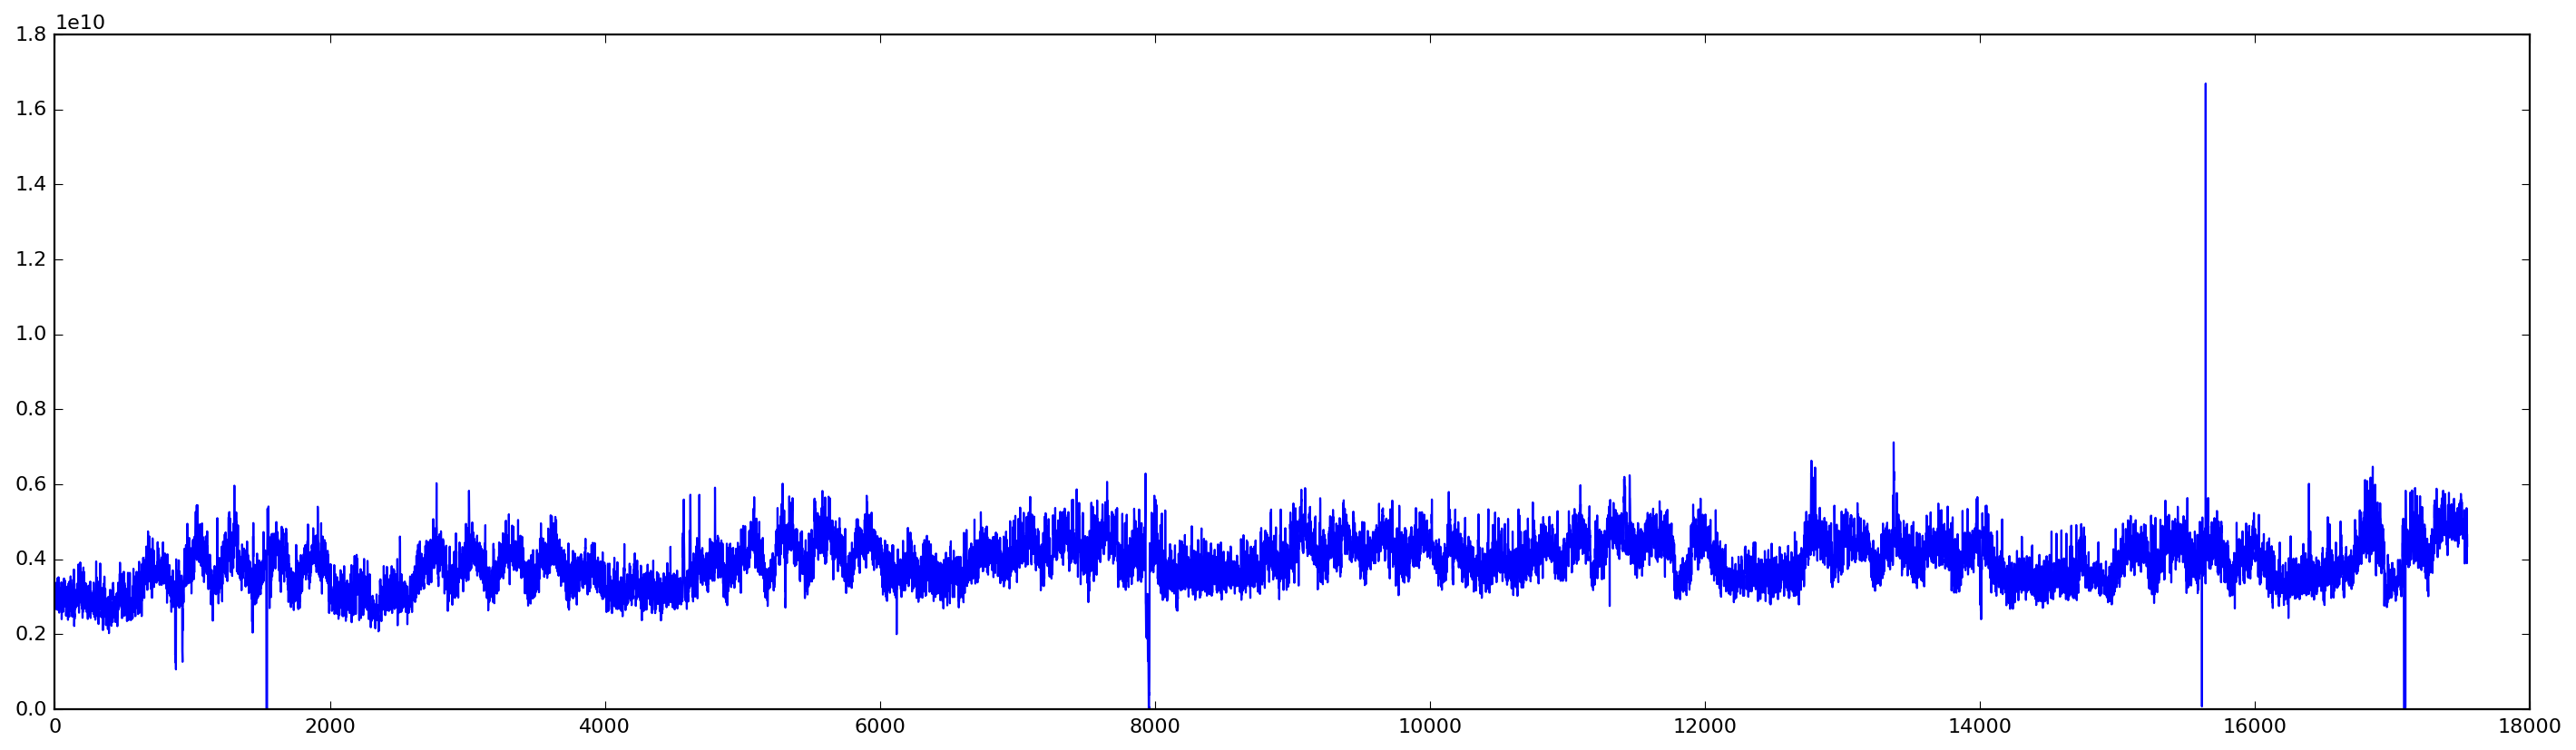

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,6), dpi=80)
plt.plot(merged_input[:,0:1])

## Display net_trasferred traffic graph  

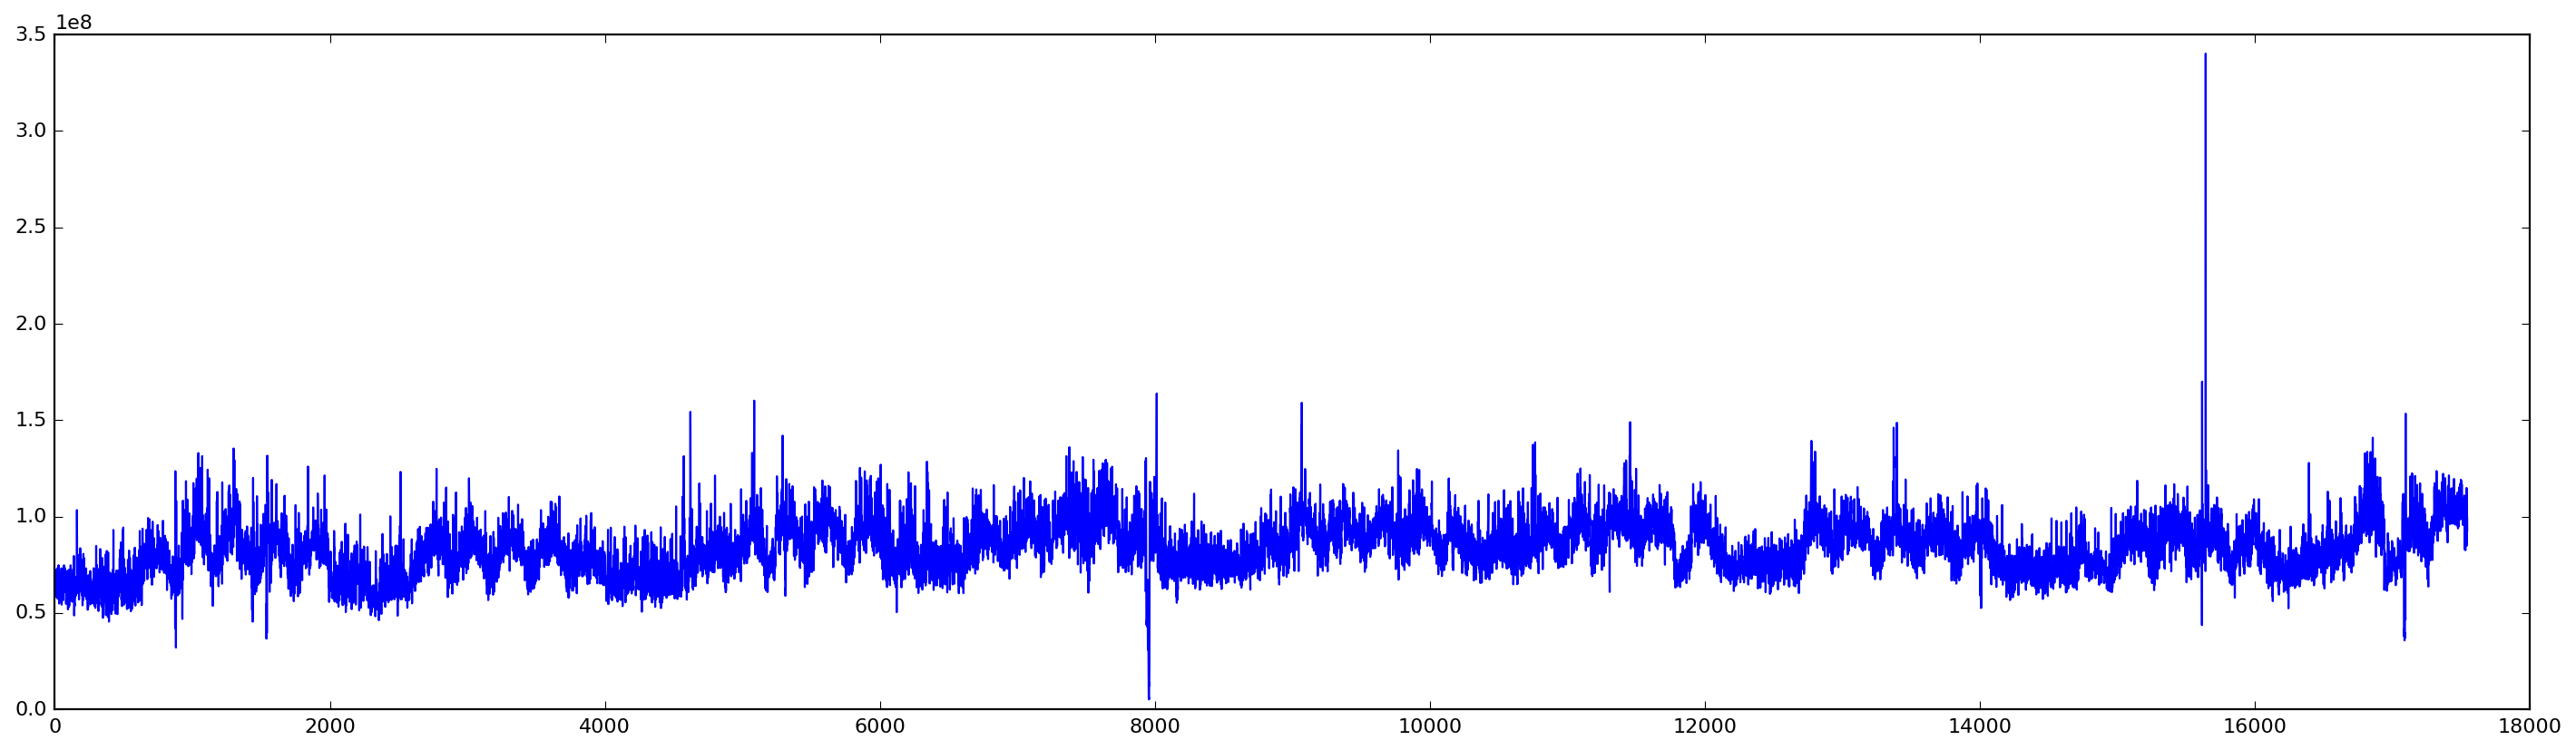

In [25]:
plt.figure(figsize=(22,6), dpi=80)
plt.plot(merged_input[:,1:2])

## Compute Hourly Network traffic

In [26]:
hourly_input=np.empty(shape=(0,2))
size=merged_input.shape[0]
for i in range(0,size,12):
    slice=merged_input[i:i+12,:]
    hourly_rev=0
    hourly_transfer=0
    for s in slice:
        hourly_rev+=s[0]
        hourly_transfer=s[1]
    hourly_input=np.append(hourly_input,[[hourly_rev,hourly_transfer]],axis=0)

## Display hourly network traffic graph  

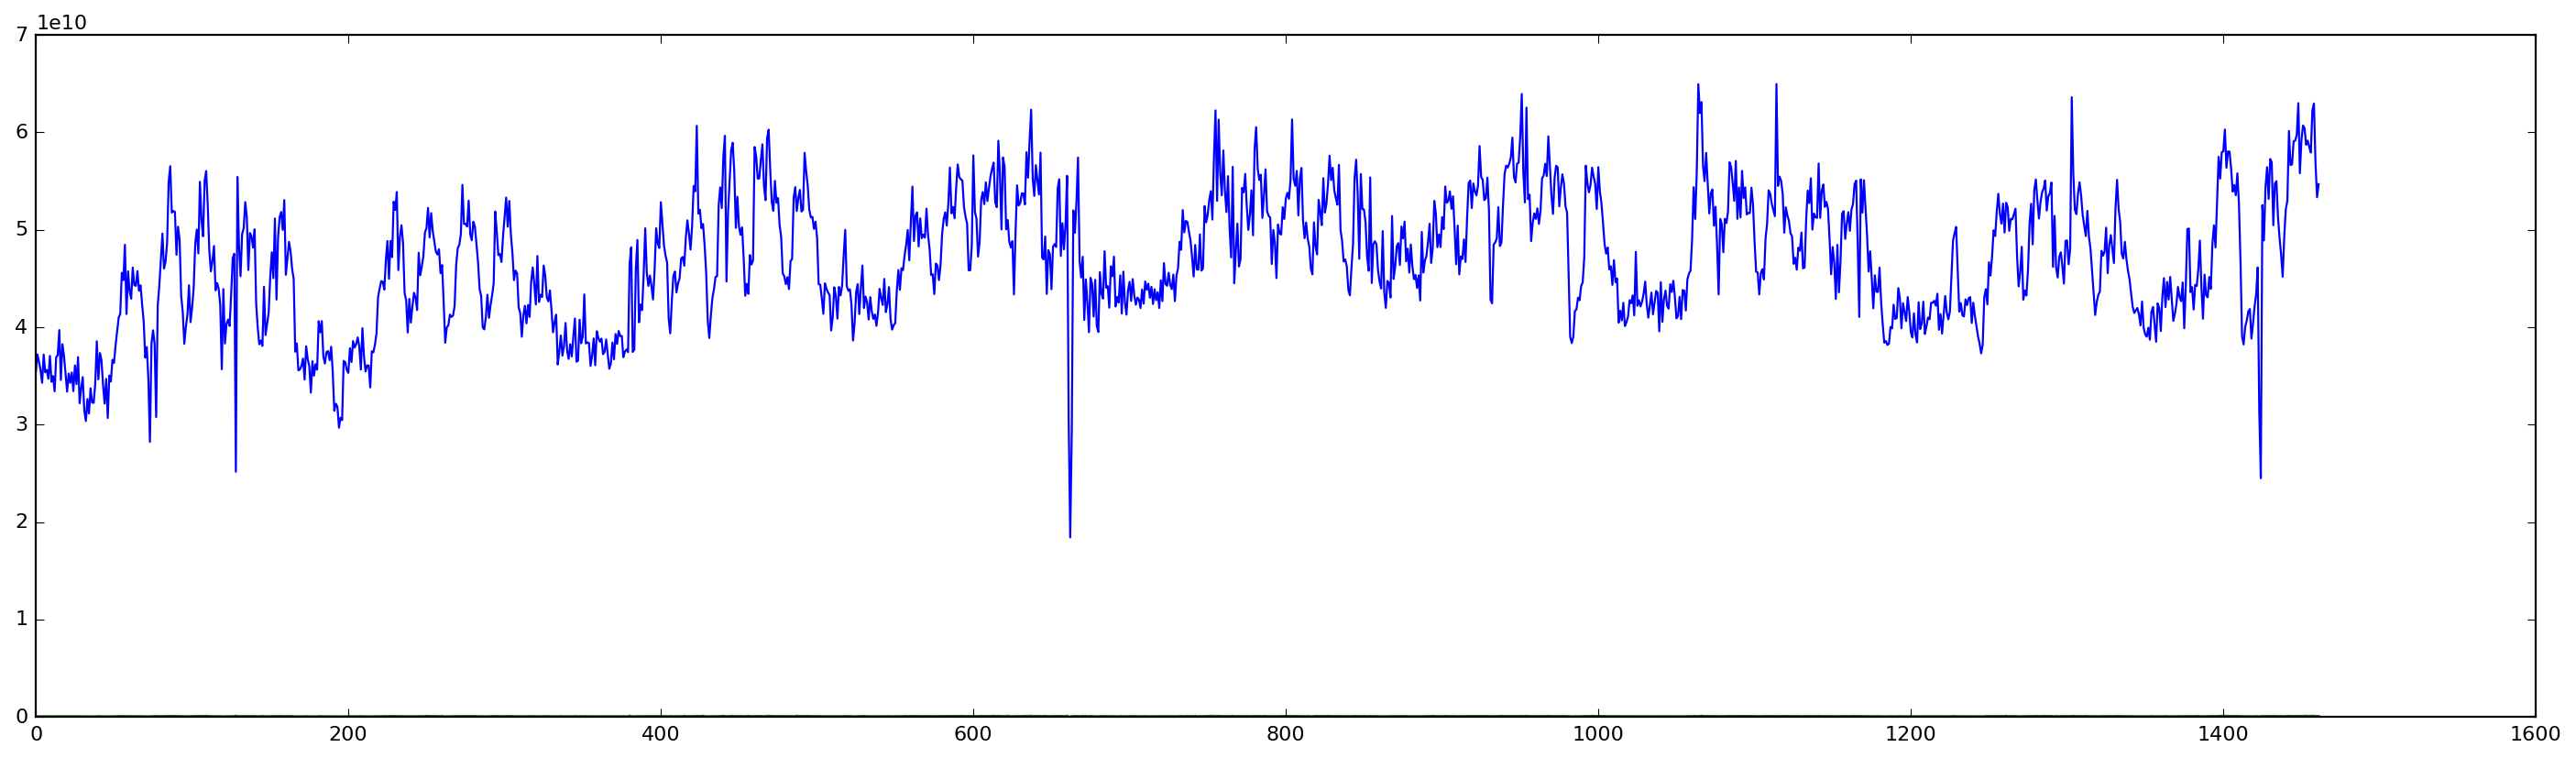

In [27]:
plt.figure(figsize=(22,6), dpi=80)
plt.plot(hourly_input)

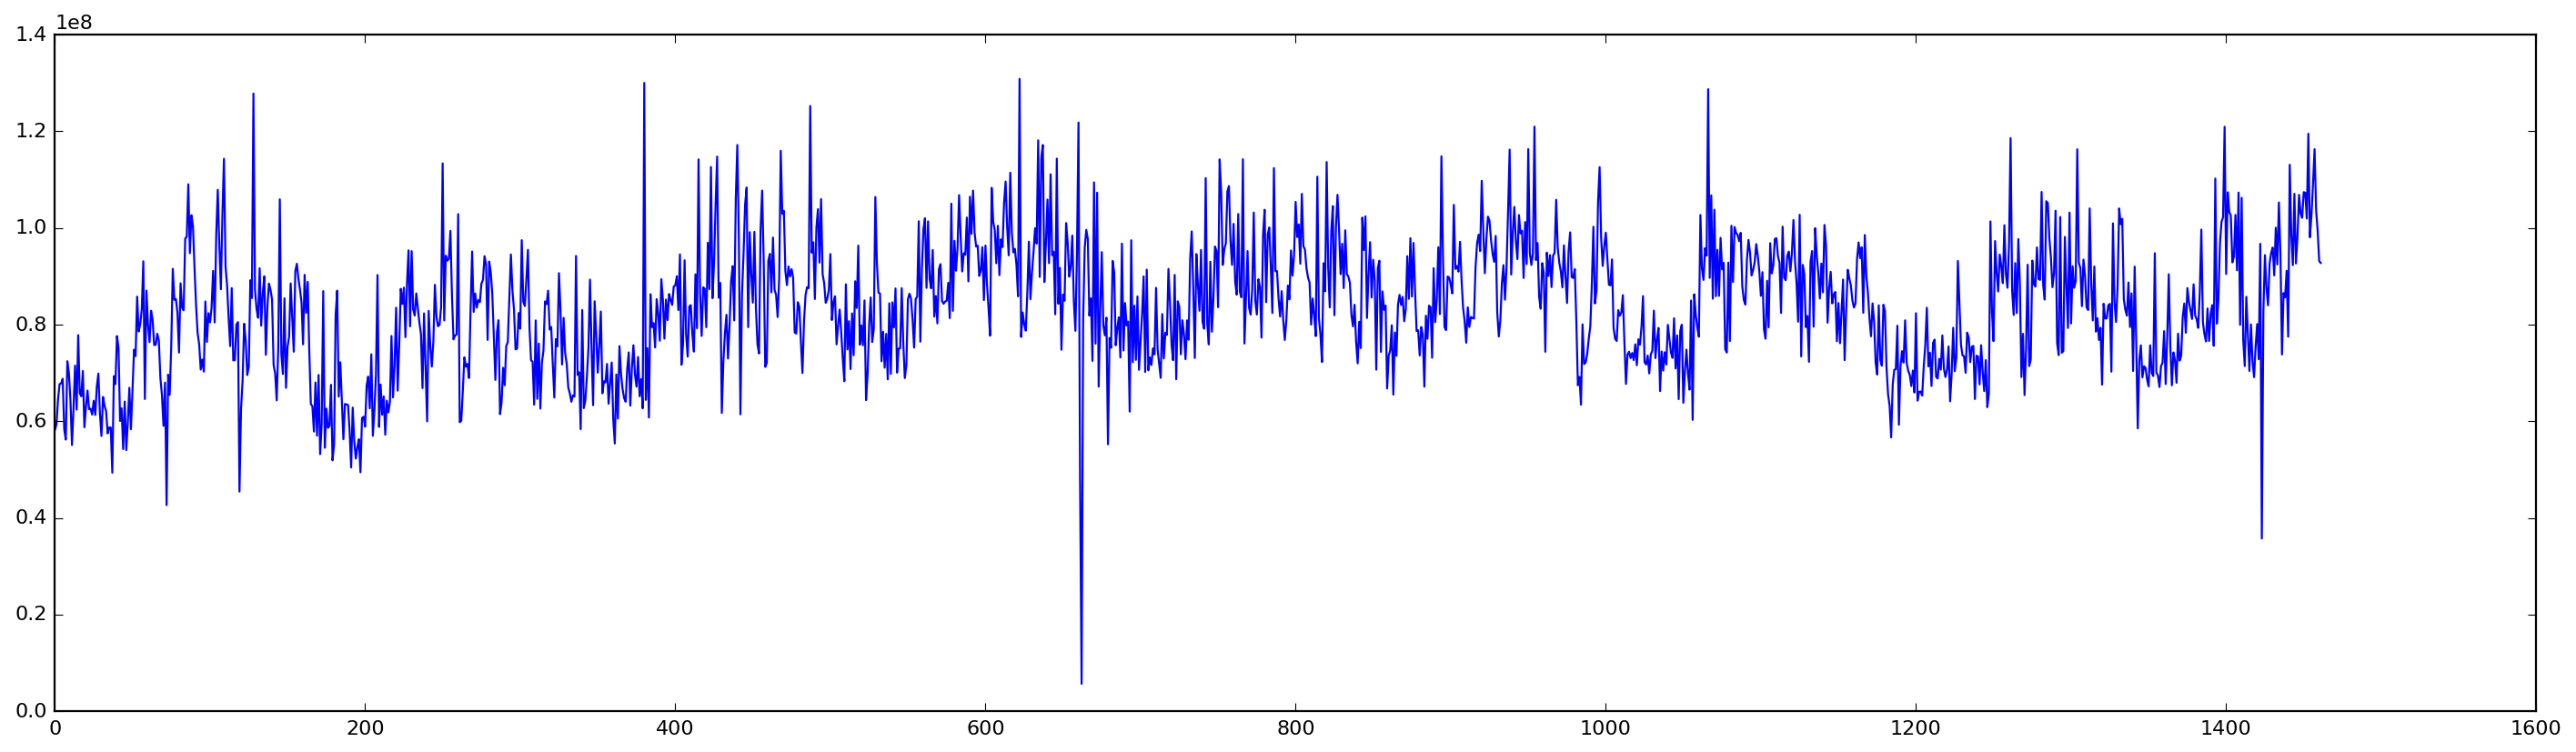

In [28]:
plt.figure(figsize=(22,6), dpi=80)

plt.plot(hourly_input[:,1:2])

## Analyze Outlier point
TODO


# Normalize data into (0,1) 

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(hourly_input[:,0:1])

# Plot diagram after data normalization

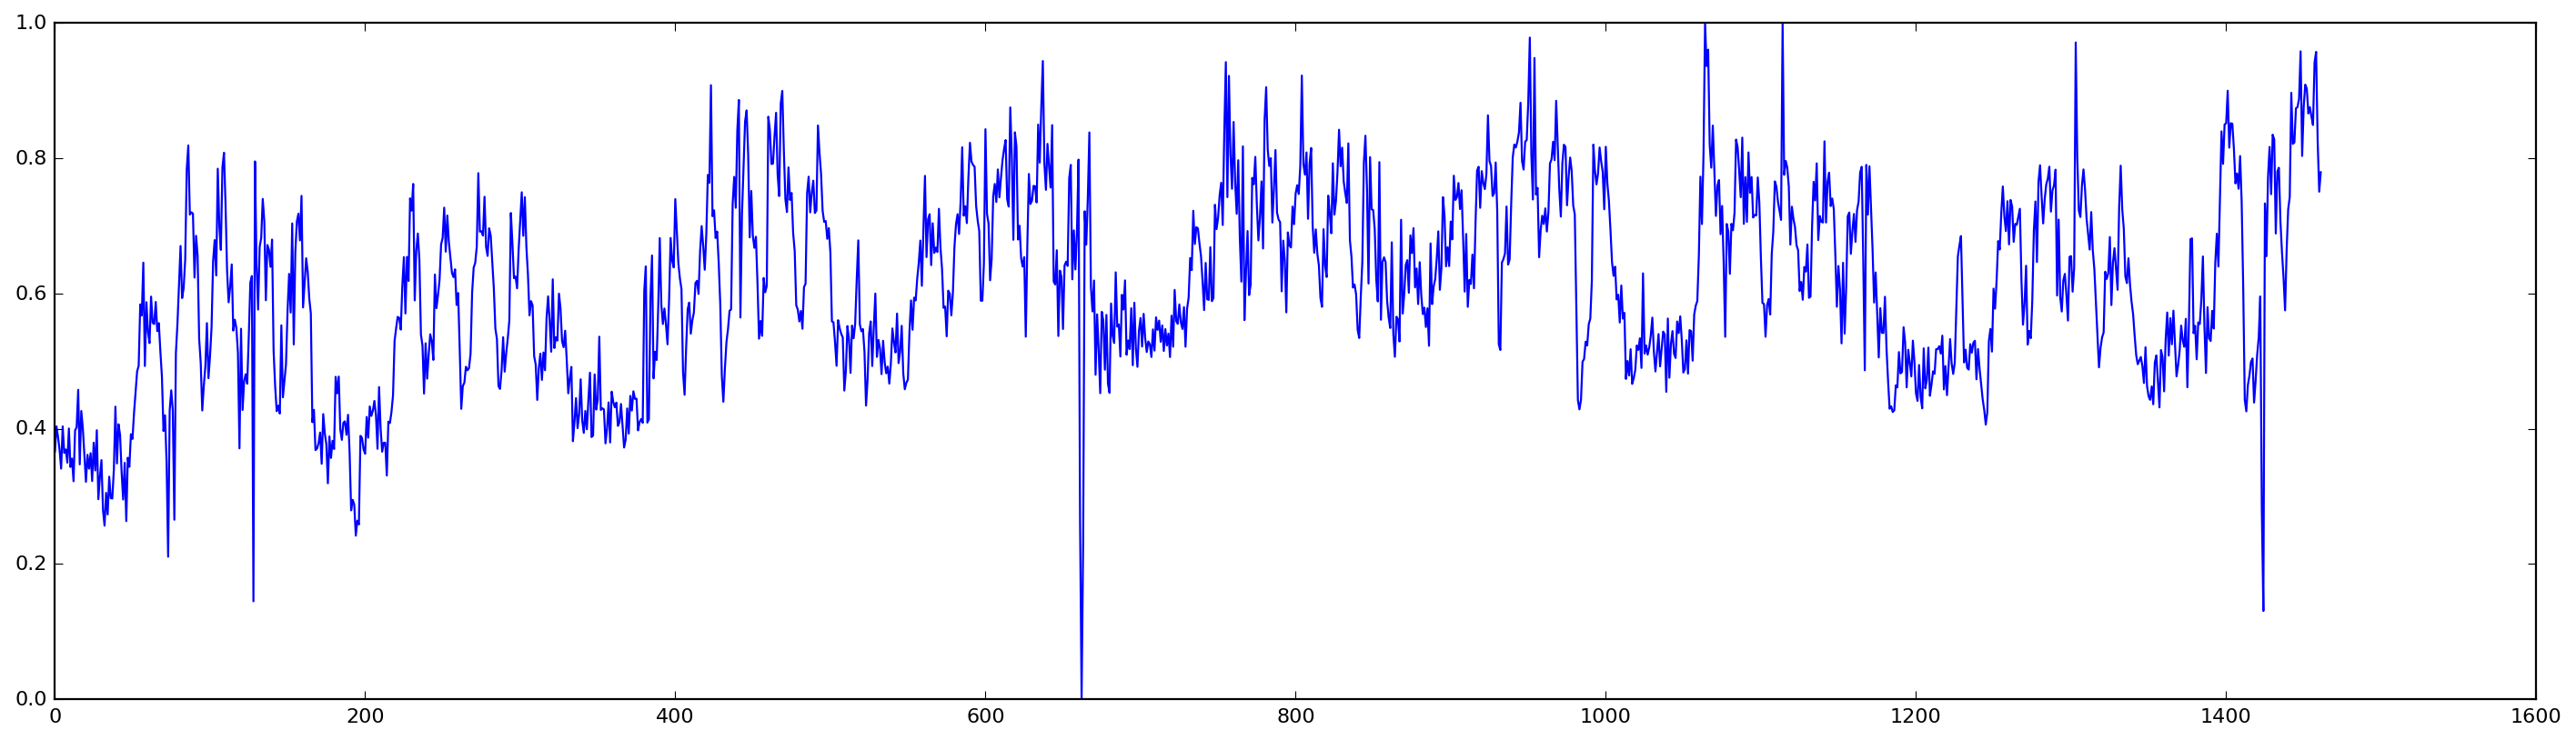

In [30]:
plt.figure(figsize=(22,6), dpi=80)
plt.plot(dataset)

# Build Model

## Making training mini-batches

In [33]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# Split data into training data and test data

In [34]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create Model
In this section, 2 layer model will be created. First layer is lstm and second layer is fully connected layer

In [36]:
# fix random seed for reproducibility
np.random.seed(7)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# Train Model

## Training Parameter 

In [37]:
epochs=10

In [38]:
model.fit(trainX, trainY, nb_epoch=epochs, batch_size=1, verbose=2)

Epoch 1/10
4s - loss: 0.0357
Epoch 2/10
3s - loss: 0.0077
Epoch 3/10
3s - loss: 0.0065
Epoch 4/10
3s - loss: 0.0059
Epoch 5/10
3s - loss: 0.0058
Epoch 6/10
3s - loss: 0.0058
Epoch 7/10
3s - loss: 0.0058
Epoch 8/10
3s - loss: 0.0058
Epoch 9/10
3s - loss: 0.0057
Epoch 10/10
3s - loss: 0.0058


# Save Training Model
Todo

# Predict through Model

In [45]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions


Train Score: 101407596379607146279690917904384.00 RMSE
Test Score: 2235313497754446856192.00 RMSE


## Training and Predict diagram  

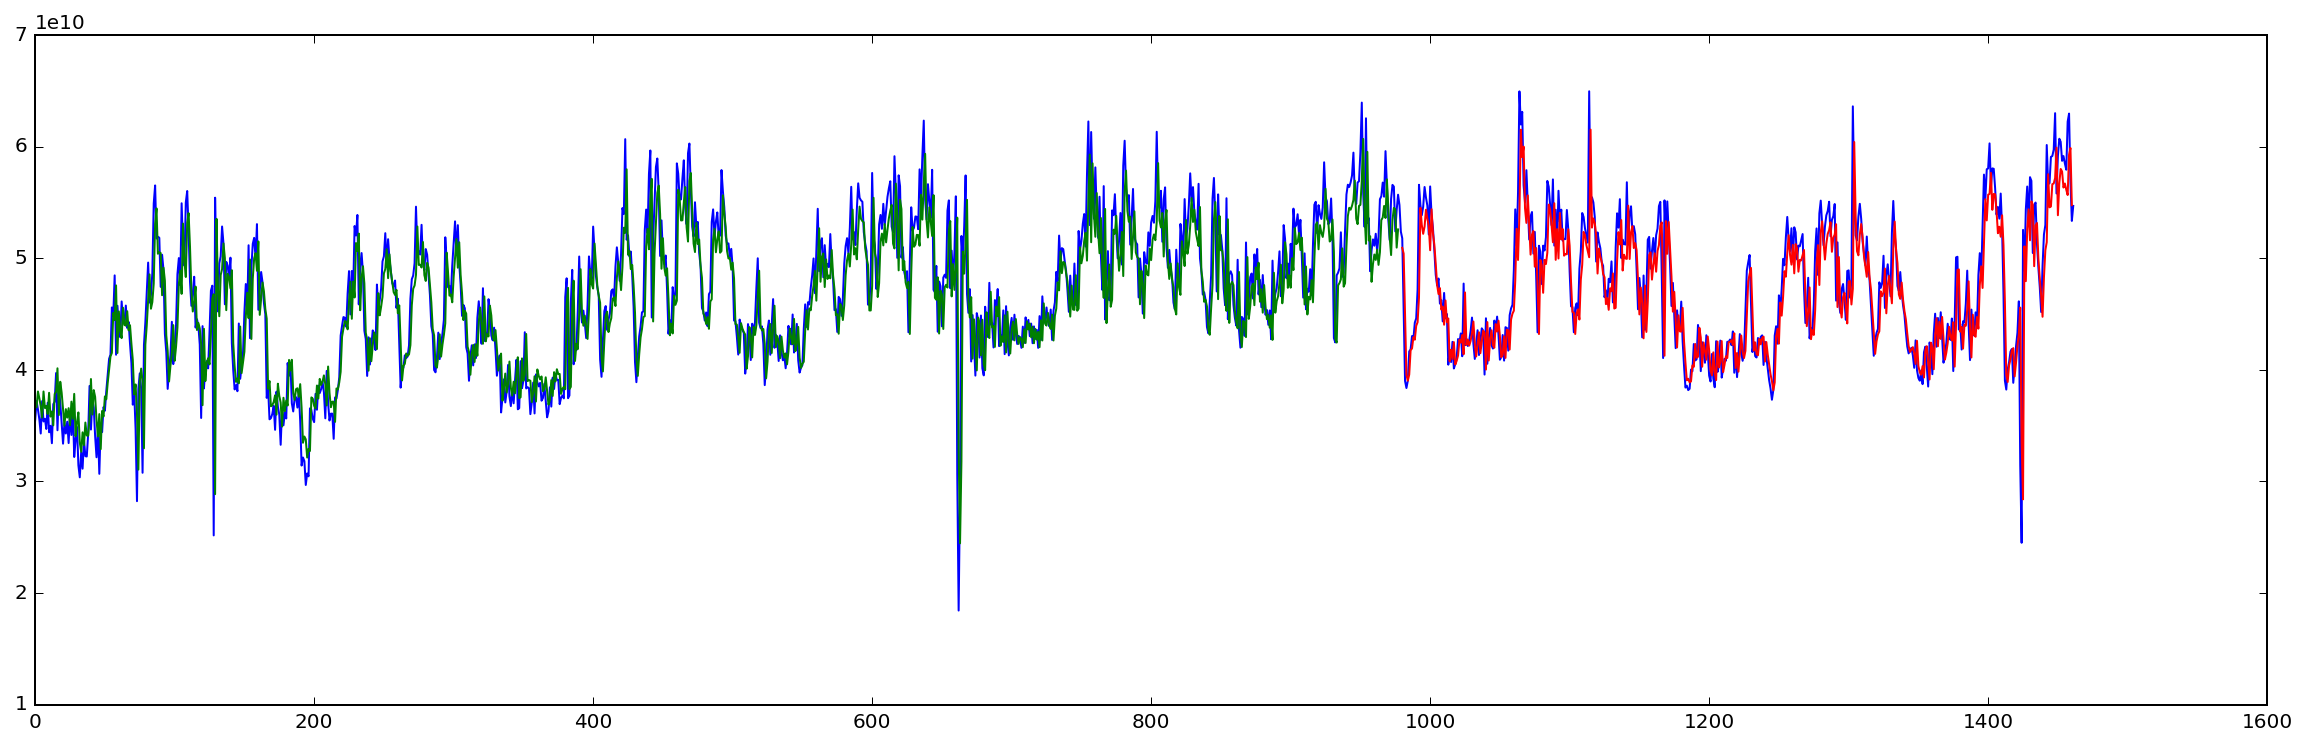

In [46]:
plt.figure(figsize=(20,6))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# How to export model 
To Do

# How to deploy keras model to production environment

To DO

# Result analysis
To DO